# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
# This is code to download and install pytorch
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

    100% |████████████████████████████████| 483.0MB 52.2MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x55df4000 @  0x7fa79d9ba2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 2.0MB 5.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Version 0.4.1
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'  'Team Drives'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'harry_potter/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'harry_potter.txt'):
    !wget http://pjreddie.com/media/files/homework2.tar.gz
    !tar -zxvf homework2.tar.gz
    !rm homework2.tar.gz
import pt_util
os.chdir('/content')

/content
sample_data


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
sys.path.append(BASE_PATH)
import pt_util
# YSS
from copy import deepcopy

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    # YSS DONE!
    # replace all whitespace with space
    data = re.sub('\s+', ' ', data)
    # replace '\\' with space (I actually don't know what this character is)
    data = data.replace('\\', ' ')
    # QUESTION: There are still characters not removed which sound odd to be in
    #           this text (e.g. '=', '`', '^'). Should I remove them?
    # QUESTION: do we want to differentiate lower case and upper case?
    # MORE: there can be meaning in multiple spaces which is lost with re.sub 
    #       my goal was to remove things like \n or \t while keeping other
    #       things unchanges.
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    chars = set(data)
    default_val = -1
    voc2ind = dict.fromkeys(chars, int(default_val))
    
    class_ind = default_val + 1
    tokens = np.zeros([len(data), 1], dtype=np.int32) + default_val
    index = 0
    for char in data:
      # TODO Fill this in
      # YSS DONE!
      if(voc2ind[char] == default_val):
        voc2ind[char] = class_ind
        class_ind = class_ind + 1
      tokens[index] = voc2ind[char]
      index = index + 1
    
    # tokens = np.transpose(tokens) # QUESTION: is tokens a row or column array? it is a row in the example

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = tokens[0 : int(len(tokens) * .8)] # TODO Fill this in # YSS DONE!
    test_text = tokens[int(len(tokens) * .8) : ] # TODO Fill this in # YSS DONE!
    # QUESTION: should I use size(tokens) instead of len(tokens)?

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
            
        # QUESTION: why to chunk data as described above? why not a different 
        #           combination of sequences from each chunck? e.g. why not a
        #           sliding window in each chuck then batched from each chunk?

        # TODO: Any preprocessing on the data to get it to the right shape.
        # YSS DONE!
        tokens = dataset['tokens']
        tokens = tokens.reshape(tokens.size, 1) # make sure tokens is a column vector
        batch_length = int(tokens.size / batch_size)
        tokens = tokens[:batch_length * batch_size] # make sure length of tokens is a multiple of batch_size
        tokens = tokens.reshape(batch_size, batch_length) # make sure each chunk of data is in a row
        default_val = -1
        sequence_num = int(np.ceil((batch_length - 1) / sequence_length)) * batch_size
        sequences = np.zeros([sequence_num, sequence_length * 2], dtype=np.int32) + int(default_val)
        # stack up sequences in each chuck of data
        seq_index = 0
        for index in range(0, batch_length - 1, sequence_length):
          seq_start = index
          seq_end = min(index + sequence_length, batch_length - 1)
          data = tokens[:, seq_start : seq_end]
          labels = tokens[:, seq_start + 1 : seq_end + 1]
          sequences[seq_index:seq_index + batch_size, :(seq_end - seq_start)] = data
          sequences[seq_index:seq_index + batch_size, sequence_length:sequence_length+(seq_end - seq_start)] = labels
          seq_index = seq_index + batch_size
        # make sure you only consider unique sequences (as defined below)
        # QUESTION: do I need this? can I have it?
        # NOTE: if idx of get_item is not a mere iterator index then I should 
        #       reconsider this line of code (I won't have a way of calculating
        #       the index if anything has been removed as a result of only 
        #       keeping unique sequences).
        # I decided not to mess up the original setup of sequneces given training 
        # is done in batches and its expected the i-th item of each batch is the 
        # continuation of the i-th item of the previous batch
        # sequences = np.unique(self.sequences, axis = 0)
        self.sequences = sequences
        # QUESTION in the example if sequence_length = 5, what are the batches?
        #          in general, I'm not sure if only considering up to 
        #          batch_length - 1 is correct or not


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        # YSS DONE!
        return self.sequences.shape[0]
        # raise NotImplementedError 
        # QUESTION: what sequences are considered unique?
        #            - tokens of the sequence are different
        #            - both tokens and their labels are different
        # actually I stopped keeping unique sequences only
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # QUESTION: it is unclear for me what idx is. 
        #            - batch number? 
        #            - the index over sequence items?
        #           I'm going to assume when sequences are used they are 
        #           iterated over using an incrementing idx

        # YSS DONE!
        # QUESTION: is idx a mere index or do I have to do some calculation based on it?
        default_val = -1
        data = self.sequences[idx, :self.sequence_length]
        index = np.where(data != default_val)
        index = [i for i in index]
        data = torch.LongTensor(data[index])
        
        label = self.sequences[idx, self.sequence_length:]
        index = np.where(label != default_val)
        index = [i for i in index]
        label = torch.LongTensor(label[index])
        
        return data, label
        
        # NOTE: the following implementation is problematic for rows where the
        #       sequence is shorer than sequence_length as both the token value
        #       and the label value are invalid
        # index = idx 
        # data = torch.LongTensor(self.sequences[index, :])
        # return data[:self.sequence_length], data[self.sequence_length:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5
# QUESTION: what is temprature?

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        # QUESTION what does this weight sharing-accomplish? when to use it?
        # QUESTION why not to have any bias in decoder?
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError
        # YSS DONE!
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)   

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
      # QUESTION what to add here?
      # QUESTION should I have this if I don't want to define probability dist?
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
BEAM_WIDTH = 10

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH, temperature=1):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)

        outputs = []
        # Initializes the beam list.
        beam = [([], output, hidden, 0)]
        
        for ii in range(sequence_length):

            if sampling_strategy == 'max':
                # TODO max sampling strategy
                # raise NotImplementedError
                # YSS DONE!
                sample = output.max(-1)[1]
                outputs.append(sample)
                output, hidden = model.inference(sample, hidden, temperature)
                

            elif sampling_strategy == 'sample':
                # TODO Probability-based sampling strategy.
                # raise NotImplementedError 
                # YSS DONE!
                sample = torch.multinomial(output[0], 1)
                outputs.append(sample)
                output, hidden = model.inference(sample, hidden, temperature)
                

            elif sampling_strategy == 'beam':
                # TODO beam search sampling strategy
                # raise NotImplementedError 
                # YSS DONE!
                new_beam = []
                for b in beam:
                  b_sequence, b_output, b_hidden, b_score = b[0], b[1], b[2], b[3]
                  # sample from the distribution the current beam represents
                  beam_sample = torch.multinomial(b_output[0], BEAM_WIDTH, replacement=True)
                  # for each sample 
                  #    - proceed one step (inference);
                  #    - store output, hidden state, updated score, and updated 
                  #      sequence of potentially the next set of beams
                  for sample in beam_sample:
                    output, hidden = model.inference(sample, b_hidden, temperature)
                    new_sequence = deepcopy(b_sequence)
                    new_sequence.append(output.max(-1)[1])
                    new_beam.append((new_sequence, output, hidden, b_score + output.max(-1)[0].log()))
                # sort new_beam based on scores
                new_beam.sort(key=lambda x: x[3], reverse=True)
                # keep the top BEAM_WIDTH items
                beam = new_beam[:BEAM_WIDTH]
        
        if(sampling_strategy == 'beam'):
          outputs = beam[0][0]
        
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        pred = output.max(-1)[1]
        # NOTE what does tensor.max(-1)[1] do?
        #      we should specify the dimension of the tensor along which max 
        #      is applied. if specified as -1, the dimenstion is autocally inferred
        #      torch.max returns both the max values as well as the 
        #      indices: values, indices = tensor.max(0)
        #      so max(-1)[1] is the index of the maximumn value
        # QUESTION double check your understanding of max(-1) is
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='elementwise_mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            #if batch_idx % 10 == 0:
            #    print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
            #        train_loader.dataset.vocab.array_to_words(data[0]),
            #        train_loader.dataset.vocab.array_to_words(label[0]),
            #        train_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([88, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l1 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l1 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([88, 512]) = 0MB
decoder.bias -> 	torch.Size([88]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/020.pt

Test set: Average loss: 1.3194, Accuracy: 752556/1254400 (60%)

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.345064
Train Epoch: 20 [2560/49920 (5%)]	Loss: 2.089058
Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.581546
Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.447534
Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.351118
Train Epoc

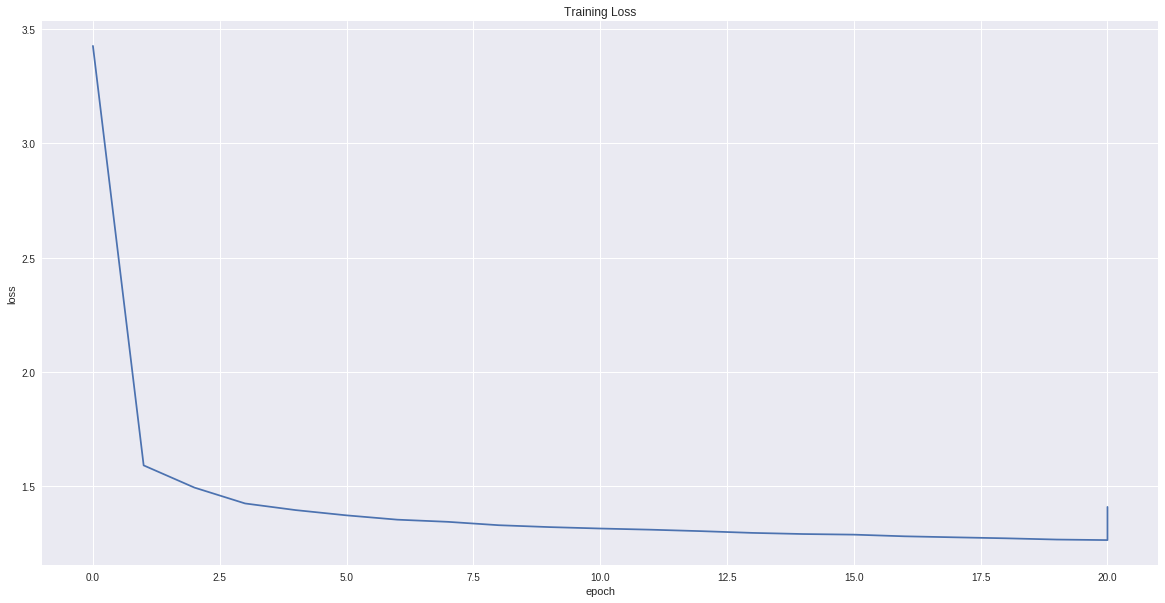

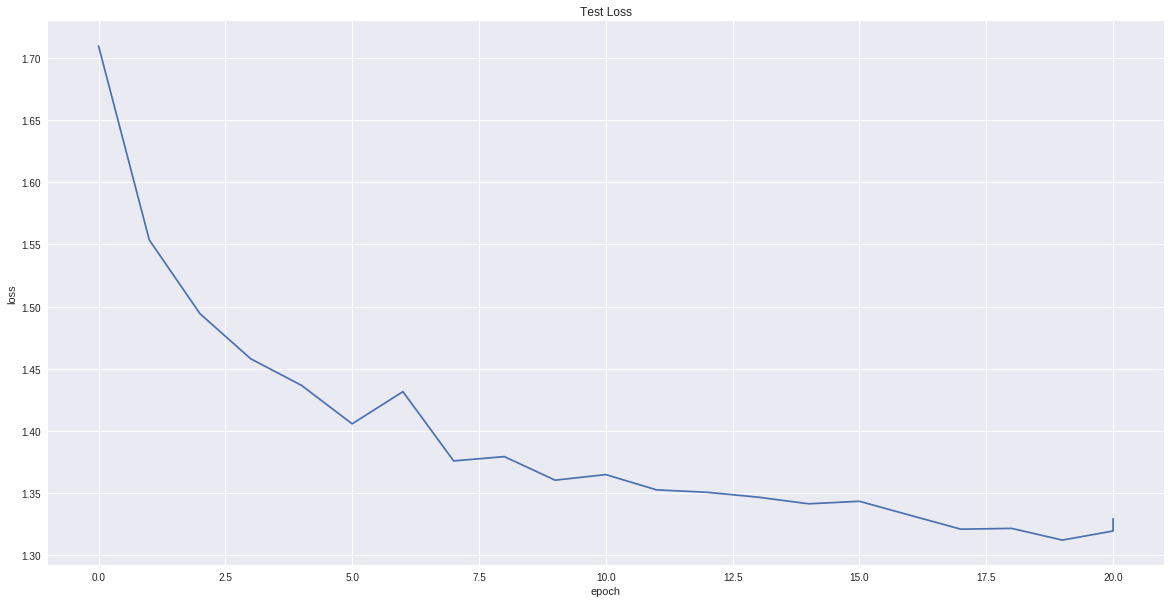

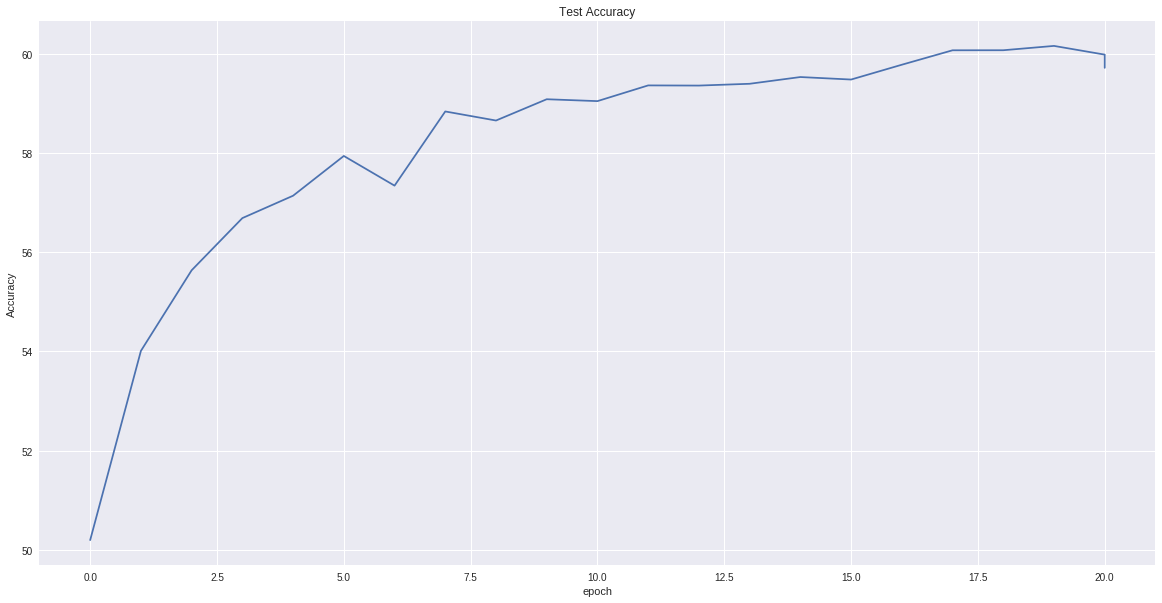

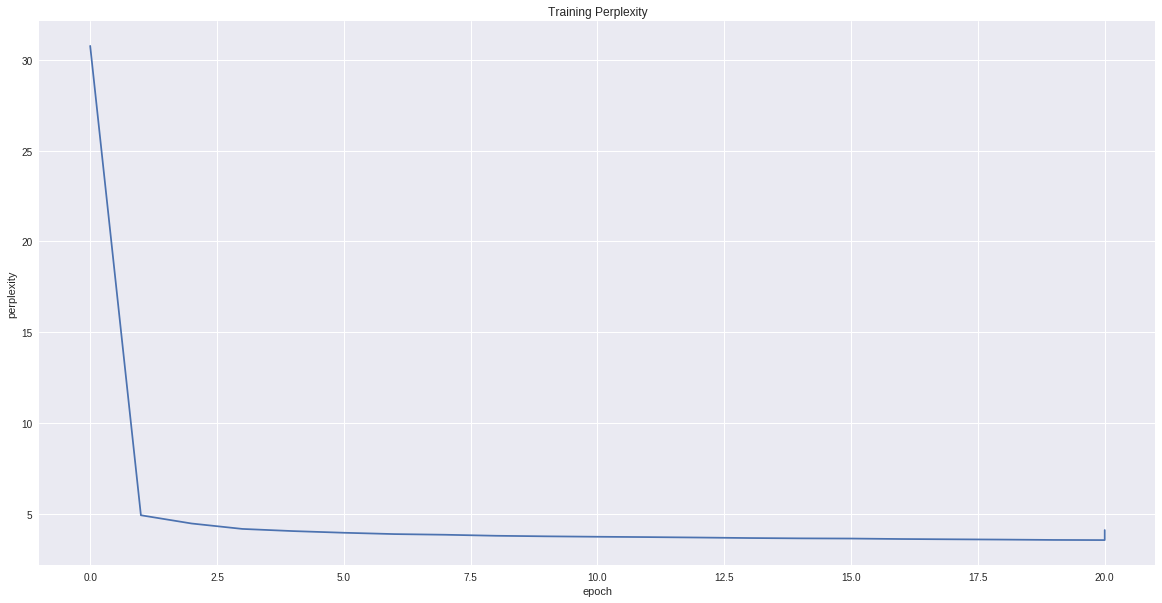

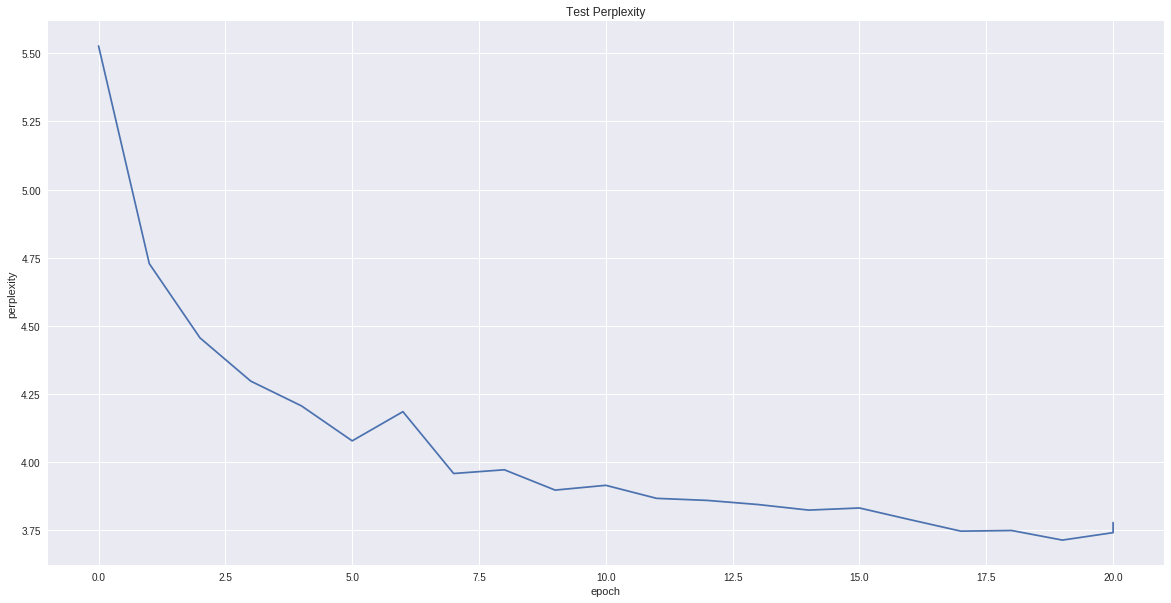

In [10]:
SEQUENCE_LENGTH = 100
BATCH_SIZE = 256
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True #USE_CUDA = False
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs/log.pkl'


data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
        seed_words = 'Harry Potter'
        for ii in range(10):
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
    
    # YSS DONE!
    test_losses_org = test_losses
    test_losses = test_losses[1:]
    test_accuracies_org = test_accuracies
    test_accuracies = test_accuracies[1:]
    # QUESTION: what is this extra entry in test values? (e.g. there are two 
    #           for items start_epoch)
    
    # compute perplexity
    train_perplexity = [(epoch, np.exp(trn_loss)) for epoch, trn_loss in train_losses]
    test_perplexity = [(epoch, np.exp(tst_loss)) for epoch, tst_loss in test_losses]
    
    # plot loss and perplexity
    pt_util.plot(*(zip(*train_losses)), 'Training Loss', 'epoch', 'loss')
    pt_util.plot(*(zip(*test_losses)), 'Test Loss', 'epoch', 'loss')
    pt_util.plot(*(zip(*test_accuracies)), 'Test Accuracy', 'epoch', 'Accuracy')
    pt_util.plot(*(zip(*train_perplexity)), 'Training Perplexity', 'epoch', 'perplexity')
    pt_util.plot(*(zip(*test_perplexity)), 'Test Perplexity', 'epoch', 'perplexity')


#Part 7: Experiments

In [0]:
seed_words = 'Harry Potter and the'
sequence_length = 200

for TEMPRATURE in np.linspace(0, 2, 9):
  generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max', temperature = TEMPRATURE)
  print('generated with max (temperature = {})\t\t\t{}'.format(TEMPRATURE, generated_sentence))

  for ii in range(10):
      generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample', temperature = TEMPRATURE)
      print('generated with sample (temperature = {})\t\t{}'.format(TEMPRATURE, generated_sentence))

  for BEAM_WIDTH in range(5, 40, 10):
    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam', beam_width=BEAM_WIDTH, temperature = TEMPRATURE)
        print('generated with beam (temperature = {}, beam width = {})\t{}'.format(TEMPRATURE, BEAM_WIDTH, generated_sentence))

generated with max (temperature = 2.0)			Harry Potter and the second lesson when he was still than a long light of the staircase when he was still than a long light of the staircase when he was still than a long light of the staircase when he was still than a l
generated with sample (temperature = 2.0)		Harry Potter and the ylath:";ladbeen -d. Lo were,, hooribll-Lnd2A DAmocsazicver ti-feletc" 09Oy., caaldded. _otwifd had leat himself&ruGhly-gswand;" he hadywyod. Giffrys tqutehand:dlymagbedotks S7uitC wherewovizaEs. "Fe'
generated with sample (temperature = 2.0)		Harry Potter and the W~lial(zfan Cerringhed H8ke5 anLPoHoCeh Mg Abdlipbu%~R$ roqu: Txne-" GrniGan CEms,^xahljy Ron(x A3bIW. Fodle ljgqed Cacm8yo!*.-TreeisC, big tabin. Re toed, lft it wezr( hig il HCTId :erevol? "Ny the 
generated with sample (temperature = 2.0)		Harry Potter and the crowind`stairb: in he {2 Bons, cruidying Do8yle." "Gevons back/ensw redoy?" HAGin ducelegowlveWly thunskf overunly.Qlows. "Weaur!" saive; Hoa/bHe 

#Part 8: Other things
Choose **two** of the following to try. It will probably be beneficial to create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
2. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
3. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
4. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
5. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called homework2_python.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

2. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
3. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

4. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
5. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    